In [0]:
!git clone https://github.com/yogeshhk/MidcurveNN.git
!mkdir midcurve_data
!cp -r /content/MidcurveNN/data /content/midcurve_data

In [0]:
%reload_ext autoreload
%autoreload 2
%reload_ext google.colab.data_table
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import cv2
import PIL
from PIL import Image
warnings.filterwarnings(action='ignore')
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn as optim
from torchvision import transforms
from fastai.vision import *
!pip install albumentations
from albumentations import (
    HorizontalFlip, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, Flip, Transpose,IAAAdditiveGaussianNoise,
    GridDistortion,  OpticalDistortion, ShiftScaleRotate, Resize,RandomRotate90, GaussNoise ,MotionBlur, MedianBlur, Blur, 
    IAAPiecewiseAffine,IAASharpen, IAAEmboss, CLAHE, Compose, OneOf, 
)
# !pip install tensorboardcolab
# from tensorboardcolab import TensorBoardColab
# tb = TensorBoardColab()
from sklearn.model_selection import StratifiedKFold

In [0]:
def read_input_image_pairs(datafolder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [0]:
input_data_folder = '/content/midcurve_data/data/input'

In [0]:
profile_pngs,midcurve_pngs = read_input_image_pairs(input_data_folder)
len(profile_pngs) == len(midcurve_pngs)

True

In [0]:
classes = [''.join(i.split('/')[-1].split('_')[0]) for i in profile_pngs]

In [0]:
df = pd.DataFrame(index = range(len(profile_pngs)) , columns = ['profile_path', 'midcurve_path','classes'])

In [0]:
df['profile_path'] = profile_pngs
df['midcurve_path'] = midcurve_pngs
df['classes'] = classes
df.head()

,profile_path,midcurve_path,classes
0,/content/midcurve_data/data/input/I_Profile.png,/content/midcurve_data/data/input/I_Midcurve.png,I
1,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I
2,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I
3,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I
4,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I


In [0]:
fnames = {key: value for key,value in enumerate(profile_pngs)}

In [0]:
class midcurvedataset(torch.utils.data.Dataset):
  '''An abstract class representing a Dataset'''
  def __init__(self, df, fname, transforms):
    '''
    intial process like reading csv file, assigning transforms
    '''
    self.df = df
    self.fnames = fnames
    self.transforms = transforms
    self.gb = self.df.groupby('profile_path')

  def __len__(self):
    '''
    returns size of input data
    '''
    return len(self.fnames)

  def __getitem__(self, id):
    '''
    return data and label at any index 
    '''
    image_id = self.fnames[id]
    df = self.gb.get_group(image_id)
    
    img_path = df['profile_path'].values[0]
    #print(img_path)

    image = PIL.Image.open(img_path).convert('RGBA')
    image = np.array(image)
    i_w, i_h, i_c = image.shape
    image = image[:,:,3]


    mask_path = df['midcurve_path'].values[0]
    #print(mask_path)
    
    mask = PIL.Image.open(mask_path).convert('RGBA')
    mask = np.array(mask)
    m_w, m_h, m_c = mask.shape
    mask = mask[:,:,3]

    
    augumentation = self.transforms(p=0.3)
    data = {'image': image, 'mask': mask}
    augumented = augumentation(**data)
    image = augumented['image']
    mask = augumented['mask']                
    return image, mask 

def aug_all(p=1):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        #HueSaturationValue(p=0.3),
    ], p=p)

In [0]:
dataset = midcurvedataset(df,fnames,aug_all)

In [0]:
image, mask = dataset[np.random.randint(0,len(profile_pngs))]

In [0]:
def plotter(img, mask):
  fig, ax = plt.subplots(1,2)   
  # img = transforms.ToPILImage()(img)
  # mask = transforms.ToPILImage()(mask)
  ax[0].imshow(img)
  ax[1].imshow(mask)
  plt.show()

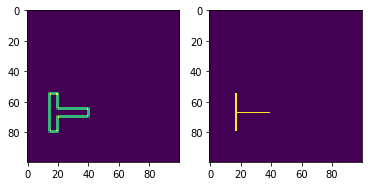

In [0]:
plotter(image, mask)

In [0]:
# #Manually experimenting with augumentation using pytorch transforms
import copy
def horizontal_flip(img, msk):
  image = copy.deepcopy(img)
  mask = copy.deepcopy(msk)
  image = transforms.ToPILImage()(transforms.ToTensor()(image).flip(-1))
  mask =  transforms.ToPILImage()(transforms.ToTensor()(mask).flip(-1))
  return image, mask

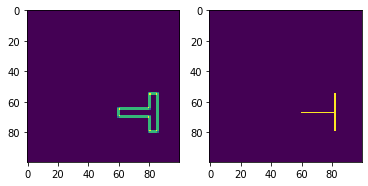

In [0]:
_img, _mask = horizontal_flip(image,mask)
plotter(_img, _mask)

In [0]:
def vertical_flip(img, msk):
  image = copy.deepcopy(img)
  mask = copy.deepcopy(msk)
  image = transforms.ToPILImage()(transforms.ToTensor()(image).flip(1))
  mask =  transforms.ToPILImage()(transforms.ToTensor()(mask).flip(1))
  return image, mask

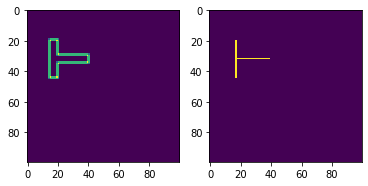

In [0]:
_img, _mask = vertical_flip(image,mask)
plotter(_img, _mask)

265


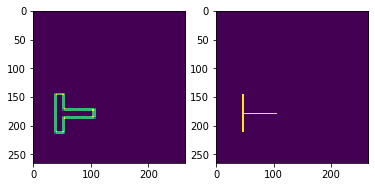

507


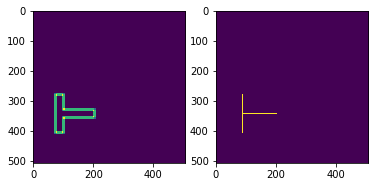

In [0]:
def resize(img, msk, size):
  image = copy.deepcopy(img)
  mask = copy.deepcopy(msk)
  image = transforms.ToPILImage()(transforms.ToTensor()(image)).resize([size,size])
  mask = transforms.ToPILImage()(transforms.ToTensor()(mask)).resize([size,size])
  return image, mask

for i in range(2):
  size = np.random.randint(0,1024)
  print(size)
  _img,_mask = resize(image,mask,size)
  plotter(_img,_mask)

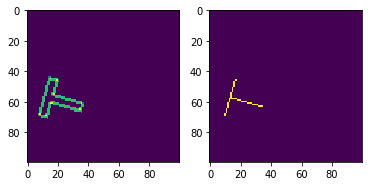

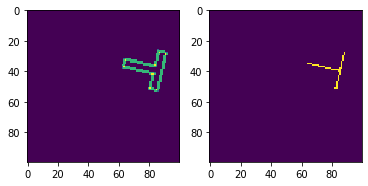

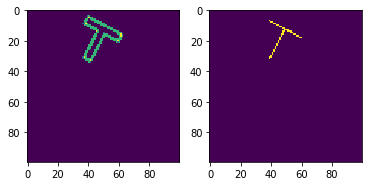

In [0]:
def rotation(img, msk, degree):
  image = copy.deepcopy(img)
  mask = copy.deepcopy(msk)
  image = transforms.ToPILImage()(transforms.ToTensor()(image)).rotate(degree)
  mask = transforms.ToPILImage()(transforms.ToTensor()(mask)).rotate(degree)
  return image, mask

for i in range(3):
  degree = np.random.randint(0,360)
  _img, _mask = rotation(image, mask, degree)
  plotter(_img, _mask)

In [0]:
df.head()

,profile_path,midcurve_path,classes
0,/content/midcurve_data/data/input/I_Profile.png,/content/midcurve_data/data/input/I_Midcurve.png,I
1,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I
2,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I
3,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I
4,/content/midcurve_data/data/input/I_Profile_mi...,/content/midcurve_data/data/input/I_Midcurve_m...,I


In [0]:
#filtering original images
original = []
for index, row in df.iterrows():
    #print(row['profile_path'])
    #print(row['profile_path'].split('/')[-1].split('_'))
    if len(row['profile_path'].split('/')[-1].split('_')) == 2:
      original.append((row['profile_path'], row['midcurve_path'], row['classes']))


In [0]:
df_original = pd.DataFrame(original, columns = ['profile_path','midcurve_path','classes'])

In [0]:
df_original

,profile_path,midcurve_path,classes
0,/content/midcurve_data/data/input/I_Profile.png,/content/midcurve_data/data/input/I_Midcurve.png,I
1,/content/midcurve_data/data/input/L_Profile.png,/content/midcurve_data/data/input/L_Midcurve.png,L
2,/content/midcurve_data/data/input/Plus_Profile...,/content/midcurve_data/data/input/Plus_Midcurv...,Plus
3,/content/midcurve_data/data/input/T_Profile.png,/content/midcurve_data/data/input/T_Midcurve.png,T


In [0]:
fnames_original = {key: value for key,value in enumerate(df_original['profile_path'].values)}
fnames_original

{0: '/content/midcurve_data/data/input/I_Profile.png',
 1: '/content/midcurve_data/data/input/L_Profile.png',
 2: '/content/midcurve_data/data/input/Plus_Profile.png',
 3: '/content/midcurve_data/data/input/T_Profile.png'}

In [0]:
dataset_original = midcurvedataset(df_original,fnames,aug_all)

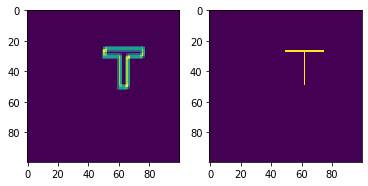

In [0]:
#iterate over it to see different augumentations
image, mask = dataset[np.random.randint(0,len(df_original['profile_path'].values))]
plotter(image, mask)

In [0]:
dataloader_original = DataLoader(
      dataset_original,
      batch_size  = 8,
      num_workers = 4,
      pin_memory = True,
      shuffle = True
  )


In [0]:
dataloader_valid = DataLoader(
      dataset_original,
      batch_size  = 8,
      num_workers = 4,
      pin_memory = True,
      shuffle = True
  )


In [0]:
data = DataBunch(train_dl = dataloader_original, valid_dl = dataloader_valid_dummy)

In [0]:
batch = next(iter(dataloader))
images, masks = batch

In [0]:
images.shape

torch.Size([4, 100, 100])

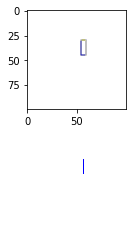

In [0]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
import torchvision
fig, ax = plt.subplots(2,1) 
grid = torchvision.utils.make_grid(images)
grid1 = torchvision.utils.make_grid(masks)
plt.axis('off')
ax[0].imshow(grid.numpy().transpose((1, 2, 0)))
ax[1].imshow(grid1.numpy().transpose((1, 2, 0)))

#plt.title(labels.numpy());

# Model

In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [0]:
def upsample(a):
	return(F.interpolate(a,scale_factor=2,mode='nearest'))
 
def concat(cur_ip, pr_ip):
	return(torch.cat((cur_ip, pr_ip), dim=1))

In [0]:
class resunet(nn.Module):
    def __init__(self):
        super(resunet, self).__init__()
        
        self.f= [32, 64,128]
        self.in_channel = 1
        #Input = 100x100x1
        self.base_layer =  nn.Conv2d(in_channels=self.in_channel , out_channels= self.f[0], kernel_size = 3, stride=1, padding=1, bias=False)
        self.base_bn = nn.BatchNorm2d(32)
        self.base_relu = nn.ReLU(inplace = True) #100x100x32

        self.e0 = ResidualBlock(self.f[0],self.f[0],stride=1)
        self.e1 = ResidualBlock(self.f[0],self.f[0],stride=1) #100x100x32

        self.e2 = ResidualBlock(self.f[0],self.f[1],stride=2) #50x50x64
        self.e3 = ResidualBlock(self.f[1],self.f[1],stride=1) #50x50x64

        self.e4 = ResidualBlock(self.f[1],self.f[2],stride=2) #25x25x128

        #bridge
        self.b =  ResidualBlock(self.f[2],self.f[2],stride=2) #25x25x128

        #Upsample
        self.d0 = ResidualBlock(192,self.f[1])
        self.d1 = ResidualBlock(96,self.f[0])
        self.d2 = ResidualBlock(self.f[0],self.in_channel)
        self.o = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, kernel_size=1, stride=1, bias=False)

        
    def forward(self, input):
        o = self.base_layer(input)
        o = self.base_bn(o)
        o = self.base_relu(o)
      
        o = self.e0(o)
        o = self.e1(o)
        s1 = o

        o = self.e2(o)
        o = self.e3(o)
        s2 = o
        
        o = self.e4(o)
        o = self.b(o)
        
        o = upsample(o)   #25x25x128
        o = concatx(o,s2) #50x50x192
        o = self.d0(o)    #50x50x64
        
        o = upsamplex(o)  #100x100x64
        o = concatx(o,s1) #100x100x96
        o = self.d1(o)    #100x100x32

        o = self.d2(o)    #100x100x1
        o = self.o(o)
        return(o)

In [0]:
model = resunet()
#model.cuda()
learn = Learner(data = data, model = model, metrics= dice)

AttributeError: ignored